## *Logical Framework*

* Matches the data in routes.dat and airports.dat(IATA combined with city names) and constructs a network based on this.

* The edges' attributes include starting and ending points(IATA), airlines, distances, aircraft type, and the number of transfers.

* Use the geographic coordinates of each city to plot a route map.

* Merge nodes belonging to the same city (e.g., Shanghai has two airports), but do not merge the edges; edges can be distinguished by their attributes.

* Observe the degree distribution, community and hubs.

## *Preliminary Preparation*

#### Airport information from wikipedia

```python
 import requests
 from bs4 import BeautifulSoup
 import pandas as pd

 # Target URL
 url = "https://en.wikipedia.org/wiki/List_of_international_airports_by_country"

 # Request webpage content
 response = requests.get(url)
 soup = BeautifulSoup(response.content, "html.parser")

# Initialize a list to store data
 data = {
     "Country": [],
     "Airport": [],
     "IATA Code": []
 }

 # Iterate through the tables and extract data
 for table in soup.find_all("table", {"class": "wikitable"}):
     country = None  
     for row in table.find_all("tr")[1:]:   # Skip the header row
         cells = row.find_all("td")
        
         # Determine if it is a country row (usually contains 3 columns)
         if len(cells) == 3:
             country = cells[0].text.strip()
             airport = cells[1].text.strip()
             iata_code = cells[2].text.strip()
         elif len(cells) == 2:  # If there are only two columns, use the previous country name
             airport = cells[0].text.strip()
             iata_code = cells[1].text.strip()
        
         # Add data to the list
         if country and airport and iata_code:
             data["Country"].append(country)
             data["Airport"].append(airport)
             data["IATA Code"].append(iata_code)

 # Convert to DataFrame
 df = pd.DataFrame(data)

 # Display or save data
 print(df)
 df.to_csv("international_airports.csv", index=False)

#### Airport information from openflights

```python
 import requests

 # URL of the routes.dat file
 url = "https://raw.githubusercontent.com/jpatokal/openflights/master/data/airports.dat"

 # Target file path
 file_path = "airports.dat"

 try:
      # Send a GET request
     response = requests.get(url)
     response.raise_for_status()  # Check if the request was successful

     # Write the content to the file
     with open(file_path, "wb") as file:
         file.write(response.content)
     print(f"The file has been successfully downloaded and saved as {file_path}")

 except requests.exceptions.RequestException as e:
     print(f"An error occurred while downloading the file: {e}")

#### Routes information from openflights

```python
import requests
# URL of the routes.dat file
url = "https://raw.githubusercontent.com/jpatokal/openflights/master/data/routes.dat"

file_path = "routes.dat"

try:
     # Send a GET request
     response = requests.get(url)
     response.raise_for_status()   # Check if the request was successful

     # Write the content to the file
     with open(file_path, "wb") as file:
         file.write(response.content)
     print(f"The file has been successfully downloaded and saved as {file_path}")

except requests.exceptions.RequestException as e:
     print(f"An error occurred while downloading the file: {e}")
```

#### World cities information from simplemaps

```python
import requests

# Replace with the actual URL copied from the "Download" button
url = "https://simplemaps.com/static/data/world-cities/basic/simplemaps_worldcities_basicv1.77.zip"

# Replace with the desired file name and path
file_path = "simplemaps_worldcities_basicv1.77.zip"

try:
    # Send a GET request
    response = requests.get(url)
    response.raise_for_status()  # Check if the request was successful

    # Save the file
    with open(file_path, "wb") as file:
        file.write(response.content)
    print(f"File downloaded successfully and saved as {file_path}")

except requests.exceptions.RequestException as e:
    print(f"Error downloading the file: {e}")
```

#### Core cities information from GaWC

```python 
import requests

# Replace with the actual URL copied from the "Download" button
url = "https://gawc.lboro.ac.uk/wp-content/uploads/2024/09/WATG24.csv"

# Replace with the desired file name and path
file_path = "WATG24.csv"

try:
    # Send a GET request
    response = requests.get(url)
    response.raise_for_status()  # Check if the request was successful

    # Save the file
    with open(file_path, "wb") as file:
        file.write(response.content)
    print(f"File downloaded successfully and saved as {file_path}")

except requests.exceptions.RequestException as e:
    print(f"Error downloading the file: {e}")

## *Network Construction*

#### Data processing

##### **Linking cities with IATA to form new file**

In [2]:
import pandas as pd

In [4]:
# Read the airports.dat file
airports_df = pd.read_csv("airports.dat", header=None, encoding="utf-8", names=[
    "ID", "Name", "City", "Country", "IATA", "ICAO", "Latitude", "Longitude",
    "Altitude", "Timezone", "DST", "TzDatabase", "Type", "Source"
])

In [6]:
# Read the routes.dat file
routes_df = pd.read_csv("routes.dat", header=None, encoding="utf-8", names=[
    "Airline", "AirlineID", "SourceIATA", "SourceAirportID", "DestinationIATA",
    "DestinationAirportID", "Codeshare", "Stops", "Equipment"
])

In [8]:
# Create a mapping from IATA codes to city names
iata_to_city = dict(zip(airports_df["IATA"], airports_df["City"]))

# Add a column for the source city
routes_df["SourceCity"] = routes_df["SourceIATA"].map(iata_to_city)

# Add a column for the destination city
routes_df["DestinationCity"] = routes_df["DestinationIATA"].map(iata_to_city)

# Save to a new CSV file
routes_df.to_csv("routes_with_cities.csv", index=False, encoding="utf-8")

print("routes_with_cities.csv completed")

routes_with_cities.csv completed


##### **Combining the city's latitude and longitude coordinates**

In [10]:
iata_to_coords = dict(zip(airports_df["IATA"], zip(airports_df["Latitude"], airports_df["Longitude"])))

In [12]:
routes_df["SourceLatitude"] = routes_df["SourceIATA"].map(lambda x: iata_to_coords.get(x, (None, None))[0])
routes_df["SourceLongitude"] = routes_df["SourceIATA"].map(lambda x: iata_to_coords.get(x, (None, None))[1])


In [14]:
routes_df["DestinationLatitude"] = routes_df["DestinationIATA"].map(lambda x: iata_to_coords.get(x, (None, None))[0])
routes_df["DestinationLongitude"] = routes_df["DestinationIATA"].map(lambda x: iata_to_coords.get(x, (None, None))[1])


In [16]:
# Save to a new CSV file
routes_df.to_csv("routes_with_cities_and_coords.csv", index=False, encoding="utf-8")

print("routes_with_cities_and_coords.csv completed")


routes_with_cities_and_coords.csv completed


#### Build the network

In [18]:
import networkx as nx
from geopy.distance import geodesic

In [19]:
routes_df = pd.read_csv("routes_with_cities_and_coords.csv", encoding="utf-8")

In [22]:
G = nx.MultiDiGraph()# Allow multiple edges between two points, as the edges have different attributes

In [24]:
missing_city_count = 0  # Number of rows with missing city data
missing_coords_count = 0  # Number of rows with missing coordinates
total_rows = len(routes_df)  # Total number of route rows

In [26]:
# Iterate through the dataset and add edges row by row
for _, row in routes_df.iterrows():
    source_city = row["SourceCity"]
    destination_city = row["DestinationCity"]

   # Skip invalid rows (missing city information)
    if pd.isna(source_city) or pd.isna(destination_city):
        missing_city_count += 1
        continue
      # Check and add the Source node
    if source_city not in G.nodes:
        G.add_node(
            source_city,
            latitude=row["SourceLatitude"] if not pd.isna(row["SourceLatitude"]) else None,
            longitude=row["SourceLongitude"] if not pd.isna(row["SourceLongitude"]) else None
        )

    # Check and add the Destination node
    if destination_city not in G.nodes:
        G.add_node(
            destination_city,
            latitude=row["DestinationLatitude"] if not pd.isna(row["DestinationLatitude"]) else None,
            longitude=row["DestinationLongitude"] if not pd.isna(row["DestinationLongitude"]) else None
        )

    # Attributes of the edge (use None for missing values)
    airline = row.get("Airline", None)
    source_iata = row.get("SourceIATA", None)
    destination_iata = row.get("DestinationIATA", None)
    stops = row.get("Stops", None)
    equipment = row.get("Equipment", None)

    # Calculate distance (handle missing latitude and longitude cases)
    try:
        source_coords = (row["SourceLatitude"], row["SourceLongitude"])
        destination_coords = (row["DestinationLatitude"], row["DestinationLongitude"])
        distance = geodesic(source_coords, destination_coords).kilometers
    except (ValueError, TypeError):
        distance = None

    # Add the edge to the graph; each row corresponds to one edge
    G.add_edge(
        source_city,
        destination_city,
        key=(airline, source_iata, destination_iata),  # Unique identifier
        airline=airline,
        source_iata=source_iata,
        destination_iata=destination_iata,
        distance=distance,
        stops=stops,
        equipment=equipment
    )


In [27]:
# Save the network to GraphML format
nx.write_graphml(G, "airline_network.graphml")
print("Network has been saved to 'airline_network.graphml'.")


Network has been saved to 'airline_network.graphml'.


In [30]:
# Print filtering statistics
print(f"total airline: {total_rows}")
print(f"missing cities rows: {missing_city_count}")
print(f"missing coords rows: {missing_coords_count}")

# Print basic information about the network
print(f"nodes: {G.number_of_nodes()}")
print(f"edges: {G.number_of_edges()}")


total airline: 67663
missing cities rows: 733
missing coords rows: 0
nodes: 3135
edges: 66930


#### Degree distribution

##### Histogram

nodes: 3135
edges: 66930
average in-degree: 21.35
average out-degree: 21.35
max in-degree: 1224
max out-degree: 1232


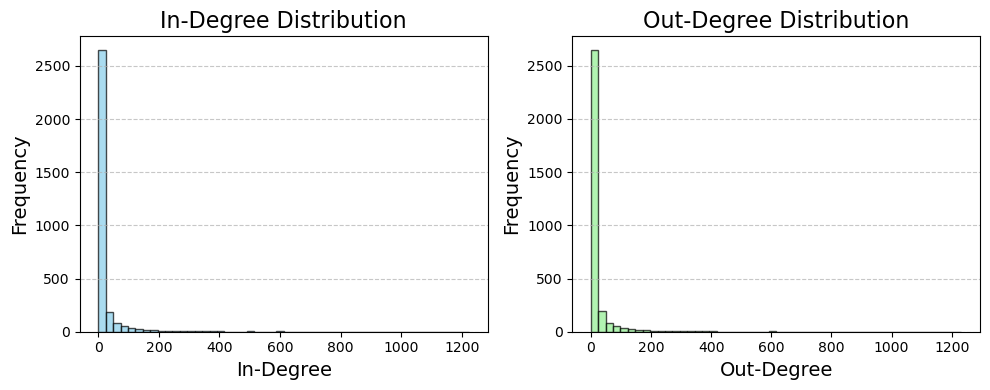

In [40]:
import matplotlib.pyplot as plt

# Calculate in-degree and out-degree
in_degrees = [deg for _, deg in G.in_degree()]   # List of in-degrees for nodes
out_degrees = [deg for _, deg in G.out_degree()]  # List of out-degrees for nodes

# Print key statistics
print(f"nodes: {G.number_of_nodes()}")  # Number of nodes in the network
print(f"edges: {G.number_of_edges()}")  # Number of edges in the network
print(f"average in-degree: {sum(in_degrees) / len(in_degrees):.2f}")  # Average in-degree
print(f"average out-degree: {sum(out_degrees) / len(out_degrees):.2f}")   # Average out-degree
print(f"max in-degree: {max(in_degrees)}")  # Maximum in-degree
print(f"max out-degree: {max(out_degrees)}")  # Maximum out-degree

# Plot the in-degree distribution
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)  # Divide the canvas into 1 row and 2 columns, first plot
plt.hist(in_degrees, bins=50, color="skyblue", edgecolor="black", alpha=0.7)  # In-degree distribution
plt.title("In-Degree Distribution", fontsize=16)  # Title
plt.xlabel("In-Degree", fontsize=14)   # Label for the x-axis
plt.ylabel("Frequency", fontsize=14)  # Label for the y-axis
plt.grid(axis="y", linestyle="--", alpha=0.7)  # Grid lines


# Plot the out-degree distribution
plt.subplot(1, 2, 2)  # Divide the canvas into 1 row and 2 columns, second plot
plt.hist(out_degrees, bins=50, color="lightgreen", edgecolor="black", alpha=0.7)  # Out-degree distribution
plt.title("Out-Degree Distribution", fontsize=16)  # Title
plt.xlabel("Out-Degree", fontsize=14)  # Label for the x-axis
plt.ylabel("Frequency", fontsize=14)  # Label for the y-axis
plt.grid(axis="y", linestyle="--", alpha=0.7)  # Grid lines


plt.tight_layout()
plt.show()

##### Scatter plot

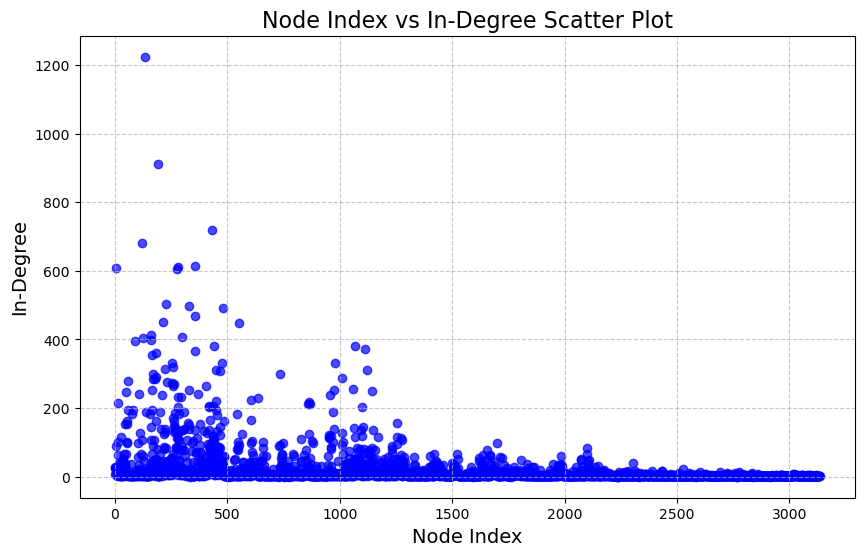

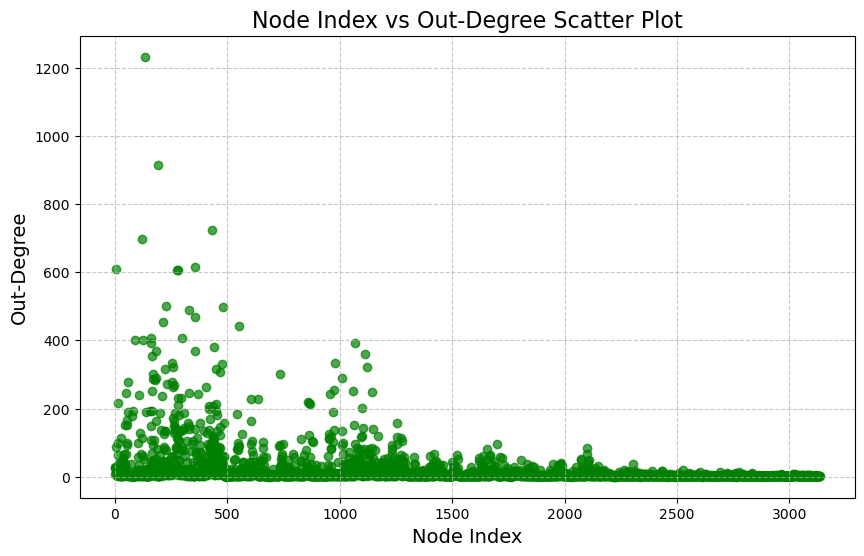

In [50]:
# Calculate in-degree and out-degree
in_degrees = [deg for _, deg in G.in_degree()]  # List of in-degrees for nodes
out_degrees = [deg for _, deg in G.out_degree()]  # List of out-degrees for nodes
nodes = range(len(in_degrees))  # Node indices (used for the x-axis)

# Plot scatter plot of node index vs in-degree
plt.figure(figsize=(10, 6))
plt.scatter(nodes, in_degrees, alpha=0.7, color="blue")  # In-degree scatter plot
plt.title("Node Index vs In-Degree Scatter Plot", fontsize=16)  # Title
plt.xlabel("Node Index", fontsize=14)  # x-axis label
plt.ylabel("In-Degree", fontsize=14)  # y-axis label
plt.grid(linestyle="--", alpha=0.7)  # Grid lines
plt.show()

# Plot scatter plot of node index vs out-degree
plt.figure(figsize=(10, 6))
plt.scatter(nodes, out_degrees, alpha=0.7, color="green")  # Out-degree scatter plot
plt.title("Node Index vs Out-Degree Scatter Plot", fontsize=16)  # Title
plt.xlabel("Node Index", fontsize=14)  # x-axis label
plt.ylabel("Out-Degree", fontsize=14)  # y-axis label
plt.grid(linestyle="--", alpha=0.7)  # Grid lines
plt.show()

##### Scatter plot(Log-Log Scale))

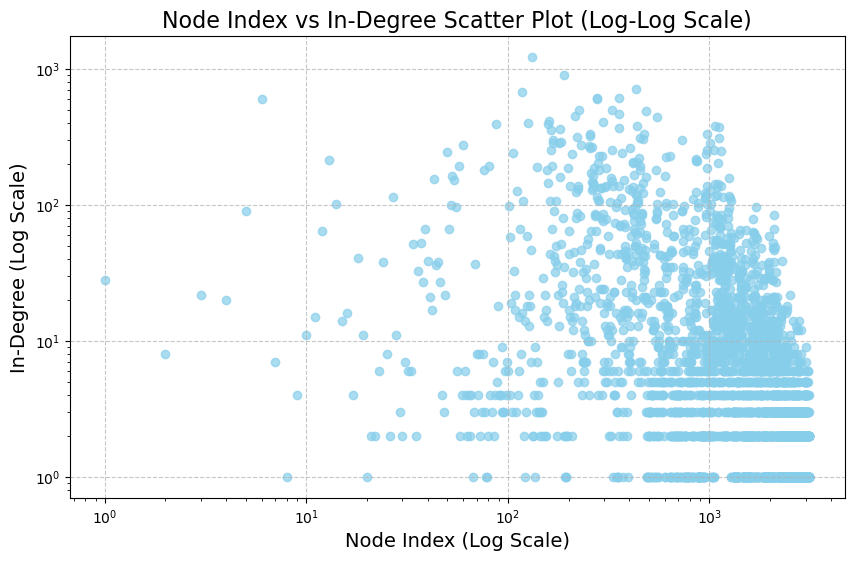

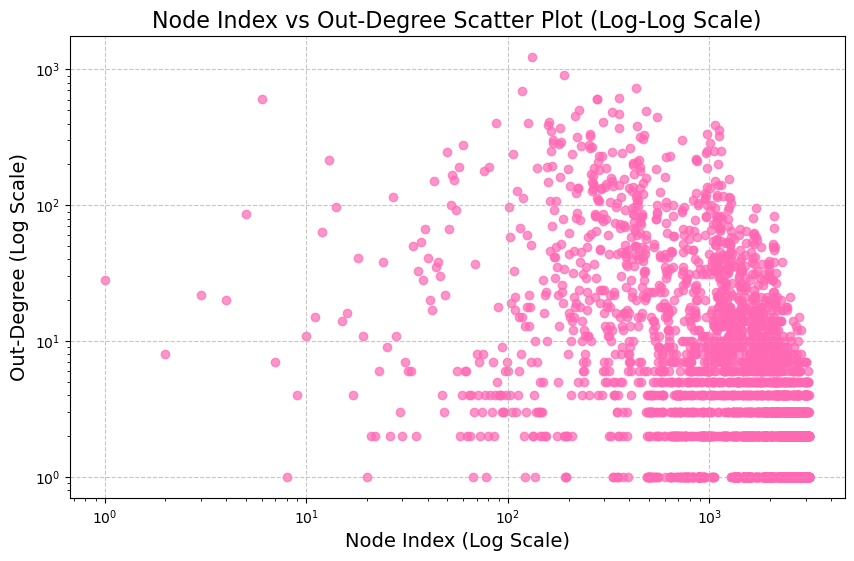

In [48]:
# Calculate in-degree and out-degree
in_degrees = [deg for _, deg in G.in_degree()]  # List of in-degrees for nodes
out_degrees = [deg for _, deg in G.out_degree()]  # List of out-degrees for nodes
nodes = range(len(in_degrees))  # Node indices (used for the x-axis)

# Plot scatter plot of node index vs in-degree (log-log scale)
plt.figure(figsize=(10, 6))
plt.scatter(nodes, in_degrees, alpha=0.7, color="skyblue")  # In-degree scatter plot
plt.xscale('log')  # Set x-axis to logarithmic scale
plt.yscale('log')  # Set y-axis to logarithmic scale
plt.title("Node Index vs In-Degree Scatter Plot (Log-Log Scale)", fontsize=16)  # Title
plt.xlabel("Node Index (Log Scale)", fontsize=14)  # x-axis label
plt.ylabel("In-Degree (Log Scale)", fontsize=14)  # y-axis label
plt.grid(linestyle="--", alpha=0.7)  # Grid lines
plt.show()

# Plot scatter plot of node index vs out-degree (log-log scale)
plt.figure(figsize=(10, 6))
plt.scatter(nodes, out_degrees, alpha=0.7, color="hotpink")  # Out-degree scatter plot
plt.xscale('log')  # Set x-axis to logarithmic scale
plt.yscale('log')  # Set y-axis to logarithmic scale
plt.title("Node Index vs Out-Degree Scatter Plot (Log-Log Scale)", fontsize=16)  # Title
plt.xlabel("Node Index (Log Scale)", fontsize=14)  # x-axis label
plt.ylabel("Out-Degree (Log Scale)", fontsize=14)  # y-axis label
plt.grid(linestyle="--", alpha=0.7)  # Grid lines
plt.show()



#### Network visualization

In [32]:
# Check the latitude and longitude information of the first few nodes
for node in list(G.nodes)[:5]:
    print(f"City: {node}, Latitude: {G.nodes[node].get('latitude')}, Longitude: {G.nodes[node].get('longitude')}")


City: Sochi, Latitude: 43.449902, Longitude: 39.9566
City: Kazan, Latitude: 55.606201171875, Longitude: 49.278701782227
City: Astrakhan, Latitude: 46.2832984924, Longitude: 48.0063018799
City: Mineralnye Vody, Latitude: 44.225101470947266, Longitude: 43.08190155029297
City: Chelyabinsk, Latitude: 55.305801, Longitude: 61.5033


In [34]:
# Filter edges where the attribute 'equipment' contains '747' or '767'
# representing cargo flight routes
matching_edges = [
    edge for edge in G.edges(data=True) 
    if isinstance(edge[2].get('equipment'), str) and ('747' in edge[2]['equipment'] or '767' in edge[2]['equipment'])
]

# Print the number of matching edges
print(f"Number of edges with '747' or '767' in equipment: {len(matching_edges)}")

# Optional: Print some of the matching edges
for edge in matching_edges[:10]:  # Print the first 10 matching edges
    print(edge)


Number of edges with '747' or '767' in equipment: 527
('Sochi', 'Tashkent', {'airline': 'HY', 'source_iata': 'AER', 'destination_iata': 'TAS', 'distance': 2415.716876027808, 'stops': 0, 'equipment': '767'})
('Moscow', 'Tashkent', {'airline': 'HY', 'source_iata': 'DME', 'destination_iata': 'TAS', 'distance': 2771.1966418582924, 'stops': 0, 'equipment': '764 767'})
('Moscow', 'London', {'airline': 'BA', 'source_iata': 'DME', 'destination_iata': 'LHR', 'distance': 2553.233136015182, 'stops': 0, 'equipment': '767 321 744'})
('Moscow', 'Shanghai', {'airline': 'MU', 'source_iata': 'SVO', 'destination_iata': 'PVG', 'distance': 6865.204042761876, 'stops': 0, 'equipment': '333 767 77W'})
('Moscow', 'Shanghai', {'airline': 'SU', 'source_iata': 'SVO', 'destination_iata': 'PVG', 'distance': 6865.204042761876, 'stops': 0, 'equipment': '333 767 77W'})
('Moscow', 'Male', {'airline': 'UN', 'source_iata': 'VKO', 'destination_iata': 'MLE', 'distance': 6552.335886336193, 'stops': 0, 'equipment': '74E 767

In [36]:
import plotly.graph_objects as go
import plotly.io as pio

# Set the renderer to notebook
pio.renderers.default = "notebook"

# Extract node longitudes and latitudes
node_longitudes = [G.nodes[node].get('longitude') for node in G.nodes if G.nodes[node].get('longitude') is not None]
node_latitudes = [G.nodes[node].get('latitude') for node in G.nodes if G.nodes[node].get('latitude') is not None]

# Extract edge longitudes and latitudes
edge_longitudes_green = []  # For regular edges (green)
edge_latitudes_green = []

edge_longitudes_blue = []  # For edges with '747' or '767' in equipment (blue)
edge_latitudes_blue = []


for edge in G.edges(data=True):
    source = edge[0]
    target = edge[1]
    attributes = edge[2] # Get the attributes of the edge

    # Retrieve the latitudes and longitudes of the source and target nodes
    source_lon = G.nodes[source].get('longitude')
    source_lat = G.nodes[source].get('latitude')
    target_lon = G.nodes[target].get('longitude')
    target_lat = G.nodes[target].get('latitude')
    
     # Check if the latitudes and longitudes exist
    if None not in (source_lon, source_lat, target_lon, target_lat):
         # Classify edges based on equipment attribute
        equipment = attributes.get('equipment', "")
        if isinstance(equipment, str) and ('747' in equipment or '767' in equipment):
            edge_longitudes_blue += [source_lon, target_lon, None]  # blue
            edge_latitudes_blue += [source_lat, target_lat, None]
        else:
            edge_longitudes_green += [source_lon, target_lon, None]  # green
            edge_latitudes_green += [source_lat, target_lat, None]

# Create scatter plot for nodes
node_trace = go.Scattergeo(
    lon=node_longitudes,
    lat=node_latitudes,
    mode='markers',
    marker=dict(size=3, color='purple', opacity=0.8), 
    name='Nodes'
)

# Create line plot for regular edges (green)
edge_trace_green = go.Scattergeo(
    lon=edge_longitudes_green,
    lat=edge_latitudes_green,
    mode='lines',
    line=dict(width=0.04, color='green'), 
    name='Edges (Normal)'
)

# Create line plot for specific equipment edges (blue)
edge_trace_blue = go.Scattergeo(
    lon=edge_longitudes_blue,
    lat=edge_latitudes_blue,
    mode='lines',
    line=dict(width=0.2, color='blue'), 
    name='Edges (Cargo)'
)

# Create the world map
fig = go.Figure()
fig.add_trace(edge_trace_green)
fig.add_trace(edge_trace_blue)
fig.add_trace(node_trace)

fig.update_geos(
    showcoastlines=True,
    showcountries=True,
    showland=True,
    resolution=110,  # Map detail resolution
    landcolor="rgb(243, 243, 243)",  # Color of the land
    countrycolor="rgb(200, 200, 200)",  # Color of country borders
    projection_type="orthographic",  # Type of Earth projection
    showocean=True,  # Display oceans
    oceancolor="rgb(230, 245, 255)"  # Color of the oceans
)

# Update layout to increase the figure size and move the legend
fig.update_layout(
    title="3D Global Network Visualization with Realistic Map",
    title_x=0.5,
    showlegend=True,
    width=1200,   # Increase figure width
    height=800,  # Increase figure height
    legend=dict(
        x=0.1,  # Adjust horizontal position of the legend
        y=0.9,  # Adjust vertical position of the legend
        bgcolor="rgba(255, 255, 255, 0.7)",  # Set background color and transparency
        bordercolor="black",  # Set border color
        borderwidth=1  # Set border width
    )
)

# Display the figure
fig.show(renderer="iframe")  # Use iframe renderer
fig.write_html("3D Global Network Visualization with Realistic Map.html")  # Save an interactive HTML file

## *Network Analysis*

#### Data processing (hubs)

In [42]:
# Extract hub cities
# Calculate the threshold (top 5% of nodes)
total_degrees = [in_deg + out_deg for in_deg, out_deg in zip(in_degrees, out_degrees)]
threshold = sorted(total_degrees, reverse=True)[int(len(total_degrees) * 0.05)]

# Extract hub airports
hub_airports = [node for node, deg in G.degree() if deg >= threshold]

print(f"Threshold for hub airports: {threshold}")
print(f"Number of hub airports: {len(hub_airports)}")

Threshold for hub airports: 202
Number of hub airports: 158


In [44]:
# Hub nodes, replaced with yellow star markers
import plotly.graph_objects as go
import plotly.io as pio

# Set the renderer to notebook
pio.renderers.default = "notebook"

# Extract the latitudes and longitudes of regular nodes and hub nodes
threshold_degree = 100  # Assume the threshold for hub nodes is a degree greater than 100
hub_nodes = [node for node, degree in G.degree() if degree > threshold_degree]

node_longitudes = [G.nodes[node].get('longitude') for node in G.nodes if G.nodes[node].get('longitude') is not None and node not in hub_nodes]
node_latitudes = [G.nodes[node].get('latitude') for node in G.nodes if G.nodes[node].get('latitude') is not None and node not in hub_nodes]

hub_longitudes = [G.nodes[node].get('longitude') for node in hub_nodes if G.nodes[node].get('longitude') is not None]
hub_latitudes = [G.nodes[node].get('latitude') for node in hub_nodes if G.nodes[node].get('latitude') is not None]

# Extract edge longitudes and latitudes
edge_longitudes_green = []  # Regular edges (green)
edge_latitudes_green = []

edge_longitudes_blue = []  # Specific equipment edges (blue)
edge_latitudes_blue = []

for edge in G.edges(data=True):
    source = edge[0]
    target = edge[1]
    attributes = edge[2]  # Get the attributes of the edge

    # Retrieve the longitudes and latitudes of the source and target nodes
    source_lon = G.nodes[source].get('longitude')
    source_lat = G.nodes[source].get('latitude')
    target_lon = G.nodes[target].get('longitude')
    target_lat = G.nodes[target].get('latitude')
    
    # If latitudes and longitudes are complete, add them to the edge lists
    if None not in (source_lon, source_lat, target_lon, target_lat):
        # Determine the edge color based on the equipment attribute
        equipment = attributes.get('equipment', "")
        if isinstance(equipment, str) and ('747' in equipment or '767' in equipment):
            edge_longitudes_blue += [source_lon, target_lon, None]   # Blue edges
            edge_latitudes_blue += [source_lat, target_lat, None]
        else:
            edge_longitudes_green += [source_lon, target_lon, None]  # Green edges
            edge_latitudes_green += [source_lat, target_lat, None]

#### Network(with hubs) visualization

In [46]:
# Create scatter plot for normal nodes
node_trace = go.Scattergeo(
    lon=node_longitudes,
    lat=node_latitudes,
    mode='markers',
    marker=dict(size=3, color='purple', opacity=0.8), 
    name='Nodes'
)

# Create scatter plot for hub nodes (star symbol)
hub_trace = go.Scattergeo(
    lon=hub_longitudes,
    lat=hub_latitudes,
    mode='markers',
    marker=dict(size=8, color='yellow', symbol='star', opacity=0.9), 
    name='Hub Nodes'
)

# Create line plot for normal edges (green)
edge_trace_green = go.Scattergeo(
    lon=edge_longitudes_green,
    lat=edge_latitudes_green,
    mode='lines',
    line=dict(width=0.04, color='green'), 
    name='Edges (Normal)'
)

# Create line plot for specific equipment edges (blue)
edge_trace_blue = go.Scattergeo(
    lon=edge_longitudes_blue,
    lat=edge_latitudes_blue,
    mode='lines',
    line=dict(width=0.2, color='blue'), 
    name='Edges (Cargo)'
)

# Create the Earth map
fig = go.Figure()
fig.add_trace(edge_trace_green)
fig.add_trace(edge_trace_blue)
fig.add_trace(node_trace)
fig.add_trace(hub_trace)

fig.update_geos(
    showcoastlines=True,
    showcountries=True,
    showland=True,
    resolution=110,  # Map detail resolution
    landcolor="rgb(243, 243, 243)",  # Land color
    countrycolor="rgb(200, 200, 200)",  # Country border color
    projection_type="orthographic",  # Earth projection type
    showocean=True,
    oceancolor="rgb(230, 245, 255)"  # Ocean color
)

# Update layout to increase the figure size and move the legend
fig.update_layout(
    title="3D Global Network Visualization with Hub Nodes Highlighted",
    title_x=0.5,
    showlegend=True,
    width=1200,  # Increase figure width
    height=800,  # Increase figure height
    legend=dict(
        x=0.1,  # Adjust the horizontal position of the legend
        y=0.9,  # Adjust the vertical position of the legend
        bgcolor="rgba(255, 255, 255, 0.7)",  # Set background color and transparency
        bordercolor="black",  # Set border color
        borderwidth=1  # Set border width
    )
)

# Display the figure
fig.show(renderer="iframe")  # Use iframe renderer
fig.write_html("3D Global Network Visualization with Hub Nodes Highlighted.html")  # Save interactive visualization

#### Extract and visualize communities

In [48]:
print("Hub Nodes:")
for node in hub_nodes:
    print(f"Node: {node}, Degree: {G.degree(node)}")

Hub Nodes:
Node: Novosibirsk, Degree: 177
Node: Moscow, Degree: 1215
Node: Baku, Degree: 128
Node: St. Petersburg, Degree: 430
Node: Yekaterinburg, Degree: 199
Node: Lima, Degree: 230
Node: Abidjan, Degree: 102
Node: Accra, Degree: 107
Node: Dakar, Degree: 134
Node: Bogota, Degree: 307
Node: Zurich, Degree: 494
Node: Bordeaux, Degree: 134
Node: Bristol, Degree: 200
Node: Geneva, Degree: 329
Node: Gran Canaria, Degree: 306
Node: Larnaca, Degree: 190
Node: Tenerife, Degree: 384
Node: Stockholm, Degree: 555
Node: Oslo, Degree: 361
Node: Manila, Degree: 386
Node: Dubai, Degree: 798
Node: Brasilia, Degree: 197
Node: Salvador, Degree: 116
Node: Sao Paulo, Degree: 481
Node: Rio De Janeiro, Degree: 255
Node: Belo Horizonte, Degree: 135
Node: Chicago, Degree: 1379
Node: St. Louis, Degree: 221
Node: Lagos, Degree: 119
Node: Barcelona, Degree: 805
Node: London, Degree: 2456
Node: Montreal, Degree: 379
Node: Jeddah, Degree: 375
Node: Nairobi, Degree: 295
Node: Bangkok, Degree: 790
Node: Singapore,

In [90]:
import networkx as nx
import community as community_louvain
import matplotlib.pyplot as plt
import plotly.graph_objects as go

# Convert the directed graph to an undirected graph (for community detection)
undirected_G = G.to_undirected()

# Perform community detection using the Louvain method
partition = community_louvain.best_partition(undirected_G)

# Get the number of communities
num_communities = len(set(partition.values()))
print(f"Number of detected communities: {num_communities}")

# Add community assignments as node attributes
nx.set_node_attributes(G, partition, 'community')

# Prepare plotting data (set colors based on community division)
community_color_map = {}
color_palette = plt.cm.get_cmap("tab20", num_communities)  # Use Matplotlib's tab20 color map

# Assign a color to each community
for community_id in set(partition.values()):
    community_color_map[community_id] = f"rgba({color_palette(community_id)[0] * 255}, {color_palette(community_id)[1] * 255}, {color_palette(community_id)[2] * 255}, 0.8)"

# Create a Plotly figure
fig = go.Figure()

# Create a separate node layer for each community
for community_id in range(num_communities):
    node_latitudes = []
    node_longitudes = []

    for node, attributes in G.nodes(data=True):
        if attributes.get('community') == community_id:
            if 'latitude' in attributes and 'longitude' in attributes:
                node_latitudes.append(attributes['latitude'])
                node_longitudes.append(attributes['longitude'])

    # Add a node layer for each community
    fig.add_trace(
        go.Scattergeo(
            lon=node_longitudes,
            lat=node_latitudes,
            mode='markers',
            marker=dict(size=5, color=community_color_map[community_id], opacity=1.0),
            name=f'Community {community_id}'  # Legend shows the community ID
        )
    )

# Extract edge latitudes and longitudes
edge_latitudes = []
edge_longitudes = []

for edge in G.edges:
    source = edge[0]
    target = edge[1]

    # Get edge latitudes and longitudes
    if (
        G.nodes[source].get('latitude') and
        G.nodes[source].get('longitude') and
        G.nodes[target].get('latitude') and
        G.nodes[target].get('longitude')
    ):
        edge_latitudes += [
            G.nodes[source]['latitude'], G.nodes[target]['latitude'], None
        ]
        edge_longitudes += [
            G.nodes[source]['longitude'], G.nodes[target]['longitude'], None
        ]

# Add an edge layer
fig.add_trace(
    go.Scattergeo(
        lon=edge_longitudes,
        lat=edge_latitudes,
        mode='lines',
        line=dict(width=0.03, color="gray"),
        name='Edges',
        opacity=0.5
    )
)

# Update map style
fig.update_geos(
    showcoastlines=True,
    showcountries=True,
    showland=True,
    resolution=110,
    landcolor="rgb(243, 243, 243)",
    countrycolor="rgb(200, 200, 200)",
    projection_type="orthographic",
    showocean=True,
    oceancolor="rgb(230, 245, 255)"
)

# Update layout
fig.update_layout(
    title="3D Global Network with Community Filtering (Louvain Method)",
    title_x=0.5,
    showlegend=True,  # Display legend
    width=1200,
    height=800,
    legend=dict(
        x=0.05,  # Legend position (left)
        y=0.95,
        bgcolor="rgba(255, 255, 255, 0.7)",
        bordercolor="black",
        borderwidth=1
    )
)

# Display the figure
fig.show(renderer="iframe")  # Use iframe renderer
fig.write_html("3D Global Network with Community Filtering (Louvain Method).html") # Save an interactive visualization

Number of detected communities: 18


/var/folders/4q/2l8kv3n14fj7m9xwxwxhd3j00000gn/T/ipykernel_43641/4122742176.py:21: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



***Viewpoints***

>Community detection algorithms (e.g., the Louvain algorithm) aim to maximize the modularity of a network, identifying groups of highly connected nodes with fewer connections between groups.
> 
> In an airline network, airports geographically close to each other typically have more flights between them, so these airports are often assigned to the same community.

* The edges (flights) in an airline network are largely constrained by geographic proximity. Long-distance flights are typically fewer than short-distance flights, making geographic location a crucial factor in community detection. For instance, the connectivity density between airports within regions such as Europe, North America, and Asia is usually high, leading to communities primarily based on geographic areas.

* The Louvain algorithm is unsupervised, meaning it does not take geographic information into account. The partitioning results are entirely based on the strength of connections between nodes. As a result, the algorithm can independently detect the influence of geographic location on connections.

* Large hubs in airline networks (e.g., London, Beijing, New York) significantly impact community detection. These nodes often connect multiple communities and may therefore be assigned to a geographically relevant community.

In [52]:
# Print basic information for each community
print("Community Information:")

community_info = {}  # Dictionary to store community information

for community_id in range(num_communities):
    # Get nodes belonging to this community
    nodes_in_community = [node for node, comm in partition.items() if comm == community_id]
    
    # Get edges within the community
    edges_in_community = [
        (u, v) for u, v, _ in G.edges(data=True) if u in nodes_in_community and v in nodes_in_community
    ]
    
    # Save community information
    community_info[community_id] = {
        "node_count": len(nodes_in_community),
        "nodes": nodes_in_community,
        "edge_count": len(edges_in_community),
    }
    
   # Print community information
    print(f"Community {community_id}:")
    print(f"  Node Count: {len(nodes_in_community)}")
    print(f"  Edge Count: {len(edges_in_community)}")
    print(f"  Nodes: {nodes_in_community}")
    print("-" * 50)



Community Information:
Community 0:
  Node Count: 179
  Edge Count: 2031
  Nodes: ['Sochi', 'Kazan', 'Astrakhan', 'Mineralnye Vody', 'Chelyabinsk', 'Novosibirsk', 'Moscow', 'Nizhnekamsk', 'Taganrog', 'Bugulma', 'Belgorod', 'Kaliningrad', 'Baku', 'St. Petersburg', 'Yekaterinburg', 'Nizhnevartovsk', 'Novy Urengoy', 'Bratsk', 'Irkutsk', 'Chita', 'Kirensk', 'Bodaibo', 'Ust-Kut', 'Lensk', 'Yakutsk', 'Mirnyj', 'Bukhara', 'Fergana', 'Khanabad', 'Namangan', 'Navoi', 'Samarkand', 'Tivat', 'Manzhouli', 'Beloyarsky', 'Nukus', 'Tyumen', 'Ufa', 'Nadym', 'Sovetskiy', 'Ukhta', 'Prague', 'Arkhangelsk', 'Solovetsky Islands', 'Murmansk', 'Naryan-Mar', 'Usinsk', 'Syktyvkar', 'Tbilisi', 'Krasnodar', 'Yakutia', 'Krasnoyarsk', 'Saratov', 'Yerevan', 'Dushanbe', 'Alma-ata', 'Khudzhand', 'Bishkek', 'Surgut', 'Aktyubinsk', 'Cheboksary', 'Elista', 'Izhevsk', 'Makhachkala', 'Petrozavodsk', 'Penza', 'Saransk', 'Ulyanovsk', 'Vorkuta', 'Voronezh', 'Samara', 'Rostov', 'Volgograd', 'Yaroslavl', 'Kurgan', 'Kirov', 'Mag

#### Extract data related to China

In [54]:
# Check if "Shanghai" is present
# Verify if hub nodes include "Shanghai"
hub_city = "Shanghai"

if hub_city in hub_nodes:
    print(f"{hub_city} is a hub node.")
else:
    print(f"{hub_city} is not a hub node.")


Shanghai is a hub node.


##### **View the nodes of provincial capital cities and developed cities in mainland China that are located within hubs**

In [56]:
# Define a list of all provincial capital city names in China
chinese_capitals = [
    "Beijing", "Shanghai", "Chongqing", "Tianjin",  # Direct-controlled municipalities
    "Guangzhou", "Shenzhen",  # Special cities
    "Hangzhou", "Nanjing", "Wuhan", "Chengdu", "Xi'an", "Shenyang", "Changchun",
    "Harbin", "Hefei", "Jinan", "Fuzhou", "Nanchang", "Zhengzhou", "Changsha",
    "Haikou", "Guiyang", "Kunming", "Lhasa", "Xining", "Yinchuan", "Urumqi",
    "Taiyuan", "Nanning", "Hohhot", "Lanzhou", "Lijiang", "Dalian", "Xiamen", 
    "Wenzhou", "Shijiazhuang", "Qingdao", "Zhuhai", "Guilin" 
]


# Initialize a list to store airports in Chinese provincial capitals
chinese_airports = []

# Iterate through the list of hub nodes to check if they are airports in China
print("Chinese Hub Nodes (Including Provincial Capitals):")
for node in hub_nodes:
    # Check if the node name represents an airport in a Chinese provincial capital
    if "China" in node or any(city in node for city in chinese_capitals):
        chinese_airports.append(node)
        print(f"Node: {node}, Degree: {G.degree(node)}")

# Print all Chinese airports
print(f"Total Chinese Hub Airports (Including Provincial Capitals): {len(chinese_airports)}")


Chinese Hub Nodes (Including Provincial Capitals):
Node: Haikou, Degree: 215
Node: Hangzhou, Degree: 502
Node: Xi'an, Degree: 551
Node: Guangzhou, Degree: 667
Node: Chongqing, Degree: 528
Node: Chengdu, Degree: 641
Node: Zhengzhou, Degree: 342
Node: Changchun, Degree: 127
Node: Harbin, Degree: 257
Node: Kunming, Degree: 539
Node: Urumqi, Degree: 298
Node: Nanjing, Degree: 326
Node: Jinan, Degree: 266
Node: Tianjin, Degree: 290
Node: Dalian, Degree: 279
Node: Nanchang, Degree: 172
Node: Lanzhou, Degree: 166
Node: Lijiang, Degree: 129
Node: Nanning, Degree: 228
Node: Beijing, Degree: 1210
Node: Shanghai, Degree: 1217
Node: Shenzhen, Degree: 463
Node: Taiyuan, Degree: 214
Node: Wuhan, Degree: 364
Node: Fuzhou, Degree: 266
Node: Shenyang, Degree: 268
Node: Wenzhou, Degree: 162
Node: Xiamen, Degree: 462
Node: Hohhot, Degree: 172
Node: Hefei, Degree: 154
Node: Guiyang, Degree: 272
Node: Shijiazhuang, Degree: 158
Node: Qingdao, Degree: 376
Node: Zhuhai, Degree: 119
Node: Guilin, Degree: 212
T

##### **Retrieve number of routes from European hub cities to Chinese capital cities** 

In [58]:
# Initialize counters
cargo_routes_to_china_capitals = 0  # Number of cargo routes from Europe to Chinese provincial capitals
passenger_routes_to_china_capitals = 0  # Number of passenger routes from Europe to Chinese provincial capitals

# Define the list of European hub cities
europeancities_hub_nodes = [
    "Zurich", "Bordeaux", "Bristol", "Geneva", "Gran Canaria", "Larnaca", "Tenerife",
    "Stockholm", "Oslo", "Barcelona", "London", "Duesseldorf", "Munich", "Hamburg",
    "Olbia", "Berlin", "Naples", "Amsterdam", "Bergamo", "Bologna", "Brussels",
    "Cologne", "Lyon", "Istanbul", "Toulouse", "Palma de Mallorca", "Paris", "Rome",
    "Madrid", "Frankfurt", "Vienna", "Warsaw", "Helsinki", "Prague", "Manchester",
    "Copenhagen", "Edinburgh", "Dublin", "Brussels", "Lisbon", "Athens", "Venice",
    "Nice", "Stuttgart", "Malaga", "Birmingham", "Budapest", "Belgrade", "Kiev",
    "Bucharest", "Marseille", "Nantes", "Luxemburg", "Newcastle", "Charleroi",
    "Eindhoven", "Thessaloniki", "Palermo", "Bologna", "Milan", "Naples", "Stavanger",
    "Alicante", "Faro", "Riga", "Vilnius", "Sevilla", "Malta", "Gdansk", "Porto",
    "Florence", "Leeds", "Belfast", "Glasgow", "East Midlands", "Liverpool",
    "Bucharest", "Dubrovnik", "Catania", "Kerkyra/corfu", "Heraklion", "Rhodos",
    "Thessaloniki", "Warsaw", "Brussels", "Athens", "Venice", "Nice", "Stuttgart"
]


# Iterate over all edges
for source, target, data in G.edges(data=True):
    # Check if the target node is a Chinese provincial capital
    if target in chinese_capitals:
        # Check if the source node is in the list of European hub cities
        if source in europeancities_hub_nodes:
            equipment = data.get("equipment", "").lower() if isinstance(data.get("equipment"), str) else ""
            airline = data.get("airline", "").lower() if isinstance(data.get("airline"), str) else ""

            # Determine if it is a cargo route
            if any(keyword in equipment for keyword in ["cargo", "freight", "747f"]) or "cargo" in airline:
                cargo_routes_to_china_capitals += 1
            else:
                passenger_routes_to_china_capitals += 1

# Print the results
print(f"Number of cargo routes from European hub cities to Chinese capital cities: {cargo_routes_to_china_capitals}")
print(f"Number of passenger routes from European hub cities to Chinese capital cities: {passenger_routes_to_china_capitals}")

Number of cargo routes from European hub cities to Chinese capital cities: 0
Number of passenger routes from European hub cities to Chinese capital cities: 85


##### **Retrieve Detailed information on passenger routes**

In [60]:
passenger_routes_details = []

# Iterate over all edges
for source, target, data in G.edges(data=True):
    # Check if the target node is a Chinese provincial capital
    if target in chinese_capitals:
        # Check if the source node is in the list of European hub cities
        if source in europeancities_hub_nodes:
            equipment = data.get("equipment", "").lower() if isinstance(data.get("equipment"), str) else ""
            airline = data.get("airline", "").lower() if isinstance(data.get("airline"), str) else ""

            # Determine if it is a passenger route
            if not (any(keyword in equipment for keyword in ["cargo", "freight", "747f"]) or "cargo" in airline):
                # Store the details of the passenger route
                passenger_routes_details.append({
                    "Source": source,
                    "Target": target,
                    "Attributes": data
                })

# Print the details of passenger routes
print("\nPassenger Routes from European hub cities to Chinese capital cities:")
for route in passenger_routes_details:
    print(f"Source: {route['Source']}, Target: {route['Target']}, Attributes: {route['Attributes']}")

# Print the total count
print(f"Total passenger routes details printed: {len(passenger_routes_details)}")



Passenger Routes from European hub cities to Chinese capital cities:
Source: Zurich, Target: Beijing, Attributes: {'airline': 'LX', 'source_iata': 'ZRH', 'destination_iata': 'PEK', 'distance': 7991.787494585086, 'stops': 0, 'equipment': '333'}
Source: Zurich, Target: Shanghai, Attributes: {'airline': 'LX', 'source_iata': 'ZRH', 'destination_iata': 'PVG', 'distance': 9051.365121035118, 'stops': 0, 'equipment': '343'}
Source: Geneva, Target: Beijing, Attributes: {'airline': 'CA', 'source_iata': 'GVA', 'destination_iata': 'PEK', 'distance': 8221.728392433324, 'stops': 0, 'equipment': '330'}
Source: Stockholm, Target: Beijing, Attributes: {'airline': 'CA', 'source_iata': 'ARN', 'destination_iata': 'PEK', 'distance': 6709.184722215161, 'stops': 0, 'equipment': '333'}
Source: Stockholm, Target: Beijing, Attributes: {'airline': 'SK', 'source_iata': 'ARN', 'destination_iata': 'PEK', 'distance': 6709.184722215161, 'stops': 0, 'equipment': '333'}
Source: London, Target: Chengdu, Attributes: {'a

##### **Retrieve Detailed information on cargo routes**

In [62]:
# Initialize a list to store cargo edge details
cargo_edges_details = []

# Iterate over all edges to filter blue edges (cargo edges)
for edge in G.edges(data=True):
    source = edge[0]
    target = edge[1]
    attributes = edge[2]  # Get edge attributes
    
   # Retrieve the equipment attribute of the edge
    equipment = attributes.get('equipment', "")
    if isinstance(equipment, str) and ('747' in equipment or '767' in equipment):
        # Store the details of the cargo edge in the list
        cargo_edges_details.append({
            "Source": source,
            "Target": target,
            "Attributes": attributes
        })

# Print details of blue edges (cargo edges)
print("Cargo Edges Details (Blue Edges):")
for edge_detail in cargo_edges_details:
    print(f"Source: {edge_detail['Source']}, Target: {edge_detail['Target']}, Attributes: {edge_detail['Attributes']}")

# Print the total number of cargo edges
print(f"Total cargo edges: {len(cargo_edges_details)}")


Cargo Edges Details (Blue Edges):
Source: Sochi, Target: Tashkent, Attributes: {'airline': 'HY', 'source_iata': 'AER', 'destination_iata': 'TAS', 'distance': 2415.716876027808, 'stops': 0, 'equipment': '767'}
Source: Moscow, Target: Tashkent, Attributes: {'airline': 'HY', 'source_iata': 'DME', 'destination_iata': 'TAS', 'distance': 2771.1966418582924, 'stops': 0, 'equipment': '764 767'}
Source: Moscow, Target: London, Attributes: {'airline': 'BA', 'source_iata': 'DME', 'destination_iata': 'LHR', 'distance': 2553.233136015182, 'stops': 0, 'equipment': '767 321 744'}
Source: Moscow, Target: Shanghai, Attributes: {'airline': 'MU', 'source_iata': 'SVO', 'destination_iata': 'PVG', 'distance': 6865.204042761876, 'stops': 0, 'equipment': '333 767 77W'}
Source: Moscow, Target: Shanghai, Attributes: {'airline': 'SU', 'source_iata': 'SVO', 'destination_iata': 'PVG', 'distance': 6865.204042761876, 'stops': 0, 'equipment': '333 767 77W'}
Source: Moscow, Target: Male, Attributes: {'airline': 'UN', 

In [64]:
cargo_edges_with_china_and_europe = []

# Filter cargo edges involving European and Chinese cities
for edge_detail in cargo_edges_details:
    source = edge_detail['Source']
    target = edge_detail['Target']
    
    # If one endpoint is a European city and the other is a Chinese city, store the edge details
    if (source in europeancities_hub_nodes and target in chinese_capitals) or (target in europeancities_hub_nodes and source in chinese_capitals):
        cargo_edges_with_china_and_europe.append(edge_detail)

# Print cargo edges involving European and Chinese cities
print("Cargo Edges with Chinese and European Cities:")
for edge_detail in cargo_edges_with_china_and_europe:
    print(f"Source: {edge_detail['Source']}, Target: {edge_detail['Target']}, Attributes: {edge_detail['Attributes']}")

# Print the total count
print(f"Total cargo edges with Chinese and European cities: {len(cargo_edges_with_china_and_europe)}")

Cargo Edges with Chinese and European Cities:
Source: Amsterdam, Target: Shanghai, Attributes: {'airline': 'CZ', 'source_iata': 'AMS', 'destination_iata': 'PVG', 'distance': 8930.494835927591, 'stops': 0, 'equipment': '74M 747'}
Source: Amsterdam, Target: Shanghai, Attributes: {'airline': 'KL', 'source_iata': 'AMS', 'destination_iata': 'PVG', 'distance': 8930.494835927591, 'stops': 0, 'equipment': '74M 747'}
Source: Beijing, Target: Vienna, Attributes: {'airline': 'OS', 'source_iata': 'PEK', 'destination_iata': 'VIE', 'distance': 7471.746466047833, 'stops': 0, 'equipment': '763 767'}
Source: Shanghai, Target: Amsterdam, Attributes: {'airline': 'CZ', 'source_iata': 'PVG', 'destination_iata': 'AMS', 'distance': 8930.494835927591, 'stops': 0, 'equipment': '74M 747'}
Source: Shanghai, Target: Amsterdam, Attributes: {'airline': 'KL', 'source_iata': 'PVG', 'destination_iata': 'AMS', 'distance': 8930.494835927591, 'stops': 0, 'equipment': '74M 747'}
Source: Vienna, Target: Beijing, Attributes

##### **Retrieve information related to Shanghai (assuming a major city collapse)**

In [66]:
# Initialize counters and sets
shanghai_routes = []  # Store routes related to Shanghai
connected_cities = set()  # Store cities connected to Shanghai

# Iterate through all edges to find routes related to Shanghai
for source, target, data in G.edges(data=True):
    if source == "Shanghai" or target == "Shanghai":
        # Add route information to the list
        shanghai_routes.append((source, target, data))
        # Add the connected city to the set
        if source == "Shanghai":
            connected_cities.add(target)
        elif target == "Shanghai":
            connected_cities.add(source)

# Print the number of routes connected to Shanghai
print(f"Total routes connected to Shanghai: {len(shanghai_routes)}")

# Print detailed information about the routes connected to Shanghai
print("Routes connected to Shanghai:")
for route in shanghai_routes:
    print(f"Source: {route[0]}, Target: {route[1]}, Attributes: {route[2]}")

# Print the connected cities
print(f"Total unique cities connected to Shanghai: {len(connected_cities)}")
print(f"Cities connected to Shanghai: {connected_cities}")


Total routes connected to Shanghai: 1217
Routes connected to Shanghai:
Source: Moscow, Target: Shanghai, Attributes: {'airline': 'MU', 'source_iata': 'SVO', 'destination_iata': 'PVG', 'distance': 6865.204042761876, 'stops': 0, 'equipment': '333 767 77W'}
Source: Moscow, Target: Shanghai, Attributes: {'airline': 'SU', 'source_iata': 'SVO', 'destination_iata': 'PVG', 'distance': 6865.204042761876, 'stops': 0, 'equipment': '333 767 77W'}
Source: Zurich, Target: Shanghai, Attributes: {'airline': 'LX', 'source_iata': 'ZRH', 'destination_iata': 'PVG', 'distance': 9051.365121035118, 'stops': 0, 'equipment': '343'}
Source: Manila, Target: Shanghai, Attributes: {'airline': '5J', 'source_iata': 'MNL', 'destination_iata': 'PVG', 'distance': 1843.997828231591, 'stops': 0, 'equipment': '320'}
Source: Manila, Target: Shanghai, Attributes: {'airline': 'MU', 'source_iata': 'MNL', 'destination_iata': 'PVG', 'distance': 1843.997828231591, 'stops': 0, 'equipment': '320'}
Source: Manila, Target: Shanghai,

In [68]:
# Initialize a list to store passenger route details
passenger_routes_details = []

# Iterate through all edges
for source, target, data in G.edges(data=True):
    # Exclude routes where Shanghai is the source or target
    if source == "Shanghai" or target == "Shanghai":
        continue

    # Check if the target node is a Chinese provincial capital
    if target in chinese_capitals:
        # Check if the source node is in the list of European hub cities
        if source in europeancities_hub_nodes:
            equipment = data.get("equipment", "").lower() if isinstance(data.get("equipment"), str) else ""
            airline = data.get("airline", "").lower() if isinstance(data.get("airline"), str) else ""

            # Determine if it is a passenger route
            if not (any(keyword in equipment for keyword in ["cargo", "freight", "747f"]) or "cargo" in airline):
                # Store the details of the passenger route
                passenger_routes_details.append({
                    "Source": source,
                    "Target": target,
                    "Attributes": data
                })

# Print the details of passenger routes
print("\nPassenger Routes from European hub cities to Chinese capital cities (excluding Shanghai):")
for route in passenger_routes_details:
    print(f"Source: {route['Source']}, Target: {route['Target']}, Attributes: {route['Attributes']}")

# Print the total count
print(f"Total passenger routes (excluding Shanghai): {len(passenger_routes_details)}")



Passenger Routes from European hub cities to Chinese capital cities (excluding Shanghai):
Source: Zurich, Target: Beijing, Attributes: {'airline': 'LX', 'source_iata': 'ZRH', 'destination_iata': 'PEK', 'distance': 7991.787494585086, 'stops': 0, 'equipment': '333'}
Source: Geneva, Target: Beijing, Attributes: {'airline': 'CA', 'source_iata': 'GVA', 'destination_iata': 'PEK', 'distance': 8221.728392433324, 'stops': 0, 'equipment': '330'}
Source: Stockholm, Target: Beijing, Attributes: {'airline': 'CA', 'source_iata': 'ARN', 'destination_iata': 'PEK', 'distance': 6709.184722215161, 'stops': 0, 'equipment': '333'}
Source: Stockholm, Target: Beijing, Attributes: {'airline': 'SK', 'source_iata': 'ARN', 'destination_iata': 'PEK', 'distance': 6709.184722215161, 'stops': 0, 'equipment': '333'}
Source: London, Target: Chengdu, Attributes: {'airline': 'BA', 'source_iata': 'LHR', 'destination_iata': 'CTU', 'distance': 8320.253500117475, 'stops': 0, 'equipment': '788'}
Source: London, Target: Beij

In [74]:
passenger_routes_details = []
airport_group = []  # Used to store tuples of source and target airports
airports = []  # Used to store unique source and target cities

# Iterate through all edges
for source, target, data in G.edges(data=True):
    # Exclude routes where Shanghai is the source or target
    if source == "Shanghai" or target == "Shanghai":
        continue

    # Check if the target node is a Chinese provincial capital
    if target in chinese_capitals:
        # Check if the source node is in the list of European hub cities
        if source in europeancities_hub_nodes:
            equipment = data.get("equipment", "").lower() if isinstance(data.get("equipment"), str) else ""
            airline = data.get("airline", "").lower() if isinstance(data.get("airline"), str) else ""

            # Determine if it is a passenger route
            if not (any(keyword in equipment for keyword in ["cargo", "freight", "747f"]) or "cargo" in airline):
                # Store the details of the passenger route
                passenger_routes_details.append({
                    "Source": source,
                    "Target": target,
                    "Attributes": data
                })
                # Add the source and target combination as a tuple to the airport_group list
                airport_group.append((source, target))

                # Check and add source and target cities to the airports list
                if source not in airports:
                    airports.append(source)
                if target not in airports:
                    airports.append(target)

# Print the details of passenger routes
print("\nPassenger Routes from European hub cities to Chinese capital cities (excluding Shanghai):")
for route in passenger_routes_details:
    print(f"Source: {route['Source']}, Target: {route['Target']}, Attributes: {route['Attributes']}")

# Print the list of airport tuples
print("\nList of airport pairs (source, target) for passenger routes:")
for airport_pair in airport_group:
    print(airport_pair)

airports = [airport.lower() for airport in airports]
# Print the list of unique source and target cities
print("\nList of unique airports (source and target):")
print(airports)

# Print the total count
print(f"Total passenger routes (excluding Shanghai): {len(passenger_routes_details)}")


Passenger Routes from European hub cities to Chinese capital cities (excluding Shanghai):
Source: Zurich, Target: Beijing, Attributes: {'airline': 'LX', 'source_iata': 'ZRH', 'destination_iata': 'PEK', 'distance': 7991.787494585086, 'stops': 0, 'equipment': '333'}
Source: Geneva, Target: Beijing, Attributes: {'airline': 'CA', 'source_iata': 'GVA', 'destination_iata': 'PEK', 'distance': 8221.728392433324, 'stops': 0, 'equipment': '330'}
Source: Stockholm, Target: Beijing, Attributes: {'airline': 'CA', 'source_iata': 'ARN', 'destination_iata': 'PEK', 'distance': 6709.184722215161, 'stops': 0, 'equipment': '333'}
Source: Stockholm, Target: Beijing, Attributes: {'airline': 'SK', 'source_iata': 'ARN', 'destination_iata': 'PEK', 'distance': 6709.184722215161, 'stops': 0, 'equipment': '333'}
Source: London, Target: Chengdu, Attributes: {'airline': 'BA', 'source_iata': 'LHR', 'destination_iata': 'CTU', 'distance': 8320.253500117475, 'stops': 0, 'equipment': '788'}
Source: London, Target: Beij

## *NLP*

#### Airport reviews information from airlinequality

In [78]:
import requests
from bs4 import BeautifulSoup
import csv

airports_city = [
    ['zurich'],
    ['beijing-capital', 'beijing-daxing'],
    ['geneva'],
    ['stockholm-arlanda', 'stockholm-bromma', 'stockholm-vasteras', 'stockholm-skavsta'],
    ['london-city', 'london-heathrow', 'london-gatwick', 'london-stansted'],
    ['chengdu'],
    ['guangzhou'],
    ['dusseldorf'],
    ['munich'],
    ['berlin-brandenburg', 'berlin-schonefeld', 'berlin-tegel', 'berlin-tempelhof'],
    ['amsterdam-schiphol'],
    ['hangzhou'],
    ['xiamen'],
    ['brussels-charleroi', 'brussels-zaventem'],
    ['istanbul'],
    ['urumqi'],
    ['paris-cdg', 'paris-orly'],
    ['rome-ciampino', 'rome-fiumicino'],
    ['vienna'],
    ['warsaw-chopin', 'warsaw-modlin', 'warsaw-radom'],
    ['madrid-barajas'],
    ['frankfurt-main', 'frankfurt-hahn'],
    ['shenyang'],
    ['helsinki-vantaa'],
    ['chongqing-jiangbei'],
    ['xian-xianyang'],
    ['copenhagen']
]

# Used to store file names (excluding .csv)
file_name_list = []

headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:103.0) Gecko/20100101 Firefox/103.0"
}

def get_page_content(airport, page):
    base_url = f"https://www.airlinequality.com/airport-reviews/{airport}-airport/page/"
    url = f"{base_url}{page}/"
    response = requests.get(url, headers=headers)
    
    if response.status_code == 200:
        return response.text
    else:
        print(f"Failed to retrieve webpage content, status code: {response.status_code}，airport: {airport}")
        return None

def parse_reviews(html_content):
    soup = BeautifulSoup(html_content, "html.parser")
    reviews = soup.find_all("div", class_="text_content")
    return reviews

# Scrape and store in CSV
for city_airports in airports_city:
    if isinstance(city_airports, list):
        # Use the prefix of the first airport name as the city name
        first_airport = city_airports[0]
        city_name = first_airport.split('-')[0]  # Extract the first word as the city name
        file_name_list.append(city_name)  # Add the city name to the list
        csv_file_name = f"{city_name}.csv"  # Append .csv for file storage

        with open(csv_file_name, 'w', newline='', encoding='utf-8') as file:
            writer = csv.writer(file)
            writer.writerow(['Comment Number', 'Review Content'])

            for airport in city_airports:
                start_page = 1
                while True:
                    html_content = get_page_content(airport, start_page)
                    if html_content is None:
                        break
                    reviews = parse_reviews(html_content)
                    if not reviews:
                        break
                    for i, review in enumerate(reviews, start=1):
                        writer.writerow([f"{airport}-{i}", review.text.strip()])
                    start_page += 1
   else:
        # For a single city, directly use the airport name prefix as the city name
        city_name = city_airports.split('-')[0]
        file_name_list.append(city_name)  # Add the city name to the list
        csv_file_name = f"{city_name}.csv"  # Append .csv for file storage

        with open(csv_file_name, 'w', newline='', encoding='utf-8') as file:
            writer = csv.writer(file)
            writer.writerow(['Comment Number', 'Review Content'])

            start_page = 1
            while True:
                html_content = get_page_content(city_airports, start_page)
                if html_content is None:
                    break
                reviews = parse_reviews(html_content)
                if not reviews:
                    break
                for i, review in enumerate(reviews, start=1):
                    writer.writerow([f"{city_airports}-{i}", review.text.strip()])
                start_page += 1

print("complete:", file_name_list)



complete: ['zurich', 'beijing', 'geneva', 'stockholm', 'london', 'chengdu', 'guangzhou', 'dusseldorf', 'munich', 'berlin', 'amsterdam', 'hangzhou', 'xiamen', 'brussels', 'istanbul', 'urumqi', 'paris', 'rome', 'vienna', 'warsaw', 'madrid', 'frankfurt', 'shenyang', 'helsinki', 'chongqing', 'xian', 'copenhagen']


In [109]:
pip install textblob

DEPRECATION: Loading egg at /opt/anaconda3/lib/python3.12/site-packages/fa2_modified-0.3.10-py3.12-macosx-11.1-arm64.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /opt/anaconda3/lib/python3.12/site-packages/fa2_modified-0.3.10-py3.12.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 626.3/626.3 kB 9.4 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


#### Emotion analysis

In [80]:
from textblob import TextBlob
import csv

# Define the sentiment analysis function
def analyze_sentiment(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity  # Return the sentiment score

# Store sentiment scores for each city
city_sentiment_scores = {}

for city_name in file_name_list:
    csv_file_name = f"{city_name}.csv"  # Append .csv suffix to read the file
    total_score = 0
    review_count = 0

    try:
        with open(csv_file_name, 'r', encoding='utf-8') as file:
            reader = csv.reader(file)
            next(reader)  # Skip the header row
            for row in reader:
                comment = row[1]
                score = analyze_sentiment(comment)
                total_score += score
                review_count += 1
    except FileNotFoundError:
        print(f"File {csv_file_name} not found, skipping this file.")
        continue

    # Calculate the average sentiment score
    if review_count > 0:
        city_sentiment_scores[city_name] = total_score / review_count
    else:
        city_sentiment_scores[city_name] = 0

# Print the sentiment analysis results
print("\nscore：")
for city, score in city_sentiment_scores.items():
    print(f"{city}: {score:.2f}")



score：
zurich: 0.12
beijing: 0.02
geneva: -0.03
stockholm: -0.02
london: 0.03
chengdu: 0.04
guangzhou: 0.03
dusseldorf: 0.03
munich: 0.07
berlin: -0.07
amsterdam: 0.04
hangzhou: 0.10
xiamen: 0.13
brussels: 0.01
istanbul: 0.00
urumqi: 0.29
paris: -0.01
rome: 0.04
vienna: 0.05
warsaw: -0.01
madrid: 0.04
frankfurt: -0.03
shenyang: 0.12
helsinki: 0.16
chongqing: 0.13
xian: 0.00
copenhagen: 0.04


In [82]:
# Calculate the sentiment score for each route
route_scores = []

for source, target in airport_group:
    # Get the sentiment values for the source and target cities
    source_sentiment = city_sentiment_scores.get(source.lower(), 0)  # Default to 0 if the city has no sentiment score
    target_sentiment = city_sentiment_scores.get(target.lower(), 0)

    # Calculate the route score as the average of the two sentiment scores
    route_score = (source_sentiment + target_sentiment) / 2
    route_scores.append({
        "Source": source,
        "Target": target,
        "Route Score": route_score
    })

# Print the scores for each route
print("\nPassenger Route Scores:")
for route in route_scores:
    print(f"Source: {route['Source']}, Target: {route['Target']}, Route Score: {route['Route Score']:.2f}")

# Sort the routes by score (optional)
sorted_route_scores = sorted(route_scores, key=lambda x: x["Route Score"], reverse=True)

# Print the routes sorted by score
print("\nSorted Passenger Route Scores (by Route Score):")
for route in sorted_route_scores:
    print(f"Source: {route['Source']}, Target: {route['Target']}, Route Score: {route['Route Score']:.2f}")


Passenger Route Scores:
Source: Zurich, Target: Beijing, Route Score: 0.07
Source: Geneva, Target: Beijing, Route Score: -0.01
Source: Stockholm, Target: Beijing, Route Score: 0.00
Source: Stockholm, Target: Beijing, Route Score: 0.00
Source: London, Target: Chengdu, Route Score: 0.04
Source: London, Target: Beijing, Route Score: 0.03
Source: London, Target: Beijing, Route Score: 0.03
Source: London, Target: Beijing, Route Score: 0.03
Source: London, Target: Beijing, Route Score: 0.03
Source: London, Target: Beijing, Route Score: 0.03
Source: London, Target: Guangzhou, Route Score: 0.03
Source: Duesseldorf, Target: Beijing, Route Score: 0.01
Source: Duesseldorf, Target: Beijing, Route Score: 0.01
Source: Munich, Target: Beijing, Route Score: 0.05
Source: Munich, Target: Beijing, Route Score: 0.05
Source: Berlin, Target: Beijing, Route Score: -0.02
Source: Berlin, Target: Beijing, Route Score: -0.02
Source: Amsterdam, Target: Guangzhou, Route Score: 0.03
Source: Amsterdam, Target: Guan

In [84]:
# Calculate route scores and integrate distance information
route_scores_with_distance = []
for route in passenger_routes_details:
    source = route["Source"]
    target = route["Target"]
    distance = route["Attributes"].get("distance", 0)  # Get distance information from Attributes

    # Get sentiment values for source and target, defaulting to 0 if not found
    source_sentiment = city_sentiment_scores.get(source.lower(), 0)
    target_sentiment = city_sentiment_scores.get(target.lower(), 0)

    # Calculate the route score as the average of sentiment values
    route_score = (source_sentiment + target_sentiment) / 2

    # Add to the results list
    route_scores_with_distance.append({
        "Source": source,
        "Target": target,
        "Route Score": route_score,
        "Distance": distance
    })

# Print the scores and distances for each route
print("\nPassenger Route Scores with Distances:")
for route in route_scores_with_distance:
    print(f"Source: {route['Source']}, Target: {route['Target']}, Route Score: {route['Route Score']:.2f}, Distance: {route['Distance']} km")

# Find the top three routes with the highest scores
top_routes_with_distance = sorted(route_scores_with_distance, key=lambda x: x["Route Score"], reverse=True)[:3]

# Print the top three routes with the highest scores
print("\nTop 3 Passenger Routes (by Route Score):")
for i, route in enumerate(top_routes_with_distance, start=1):
    print(f"Rank {i}: Source: {route['Source']}, Target: {route['Target']}, Route Score: {route['Route Score']:.2f}, Distance: {route['Distance']} km")



Passenger Route Scores with Distances:
Source: Zurich, Target: Beijing, Route Score: 0.07, Distance: 7991.787494585086 km
Source: Geneva, Target: Beijing, Route Score: -0.01, Distance: 8221.728392433324 km
Source: Stockholm, Target: Beijing, Route Score: 0.00, Distance: 6709.184722215161 km
Source: Stockholm, Target: Beijing, Route Score: 0.00, Distance: 6709.184722215161 km
Source: London, Target: Chengdu, Route Score: 0.04, Distance: 8320.253500117475 km
Source: London, Target: Beijing, Route Score: 0.03, Distance: 8175.310793892793 km
Source: London, Target: Beijing, Route Score: 0.03, Distance: 8187.03744266877 km
Source: London, Target: Beijing, Route Score: 0.03, Distance: 8175.310793892793 km
Source: London, Target: Beijing, Route Score: 0.03, Distance: 8187.03744266877 km
Source: London, Target: Beijing, Route Score: 0.03, Distance: 8175.310793892793 km
Source: London, Target: Guangzhou, Route Score: 0.03, Distance: 9512.93413672746 km
Source: Duesseldorf, Target: Beijing, Rou